In [1]:
def normalize(x):
    return x/255 

In [2]:
import numpy as np
normalize(np.array([120,329,255])) 

array([0.47058824, 1.29019608, 1.        ])

In [3]:
def one_hot_encode(x):
    output = np.zeros((len(x),10))
    for i in range(len(x)):
        output[i][x[i]] = 1  
    return output

In [4]:
one_hot_encode(np.array([1,3,6,2,4,9])) 

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [5]:

import helper
helper.preprocess_and_save_data('cifar-10-batches-py', normalize, one_hot_encode)

In [6]:
import pickle


valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):

    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name = 'x')

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
neural_net_image_input([32, 32, 3]) 

<tf.Tensor 'x:0' shape=(?, 32, 32, 3) dtype=float32>

In [9]:
def neural_net_label_input(n_classes):

    return tf.placeholder(tf.float32, [None, n_classes], name = 'y')

In [10]:
neural_net_label_input(10) 

<tf.Tensor 'y:0' shape=(?, 10) dtype=float32>

In [11]:
def neural_net_keep_prob_input():

    return tf.placeholder(tf.float32, None, name = 'keep_prob')

In [12]:
def conv2d_avgpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, keep_prob):

    weight = tf.Variable(tf.random_normal([conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3],conv_num_outputs]))
    bias = tf.Variable(tf.random_normal([conv_num_outputs]))
    x = tf.nn.conv2d(x_tensor, weight, strides= [1,conv_strides[0],conv_strides[1],1], padding = 'VALID')
    x = tf.nn.bias_add(x, bias)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.nn.avg_pool(x, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME') 
    x = tf.nn.sigmoid(x)
    return x

In [16]:
conv2d_avgpool(tf.placeholder(tf.float32, [None, 32,32,3]), 6, (5,5), (1,1), (2,2), (2,2), 0.8) # 测试

<tf.Tensor 'Sigmoid:0' shape=(?, 14, 14, 6) dtype=float32>

In [17]:
import tensorflow.contrib as tfc
def flatten(x_tensor):

    return tfc.layers.flatten(x_tensor)

In [18]:
flatten(tf.placeholder(tf.float32, [None, 16,16,10])) 

<tf.Tensor 'Flatten/flatten/Reshape:0' shape=(?, 2560) dtype=float32>

In [19]:
def fully_conn(x_tensor, num_outputs):

    return tfc.layers.fully_connected(x_tensor, num_outputs)

In [20]:
fully_conn(tf.placeholder(tf.float32, [None, 2560]), 120) 

<tf.Tensor 'fully_connected/Relu:0' shape=(?, 120) dtype=float32>

In [21]:
def output(x_tensor, num_outputs):

    return tfc.layers.fully_connected(inputs = x_tensor, num_outputs = num_outputs, activation_fn=None)

In [22]:
output(tf.placeholder(tf.float32, [None, 120]), 10) 

<tf.Tensor 'fully_connected_1/BiasAdd:0' shape=(?, 10) dtype=float32>

In [23]:
def LeNet(x, keep_prob):
    # C1 and S2 layer 
    x = conv2d_avgpool(x, 6, (5,5), (1,1), (2,2), (2,2), keep_prob)
    # C3 and S4 layer
    x = conv2d_avgpool(x, 16, (5,5), (1,1), (2,2), (2,2), keep_prob)
    # C5 layer
    weight = tf.Variable(tf.random_normal([5, 5, x.get_shape().as_list()[3],120]))
    bias = tf.Variable(tf.random_normal([120]))
    x = tf.nn.conv2d(x, weight, strides= [1,5,5,1], padding = 'VALID')
    x = tf.nn.bias_add(x, bias)
    x = flatten(x)
    # F6 layer
    x= fully_conn(x, 84)
    # ouput layer
    x = output(x, 10)

    return x

In [24]:
tf.reset_default_graph()


x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()


logits = LeNet(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')


cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)


correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [25]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):

    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})
    pass

In [26]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):

    loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print(loss)
    print(valid_acc)
    pass

In [27]:
epochs = 30
batch_size = 128
keep_probability = 0.9

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  2.4226975
0.1394
Epoch  1, CIFAR-10 Batch 2:  2.214649
0.1918
Epoch  1, CIFAR-10 Batch 3:  2.012265
0.2236
Epoch  1, CIFAR-10 Batch 4:  2.065
0.2442
Epoch  1, CIFAR-10 Batch 5:  2.1701667
0.262
Epoch  2, CIFAR-10 Batch 1:  2.2422721
0.2646
Epoch  2, CIFAR-10 Batch 2:  2.0374207
0.2748
Epoch  2, CIFAR-10 Batch 3:  1.7499287
0.2778
Epoch  2, CIFAR-10 Batch 4:  1.9498079
0.2774
Epoch  2, CIFAR-10 Batch 5:  2.0379622
0.293
Epoch  3, CIFAR-10 Batch 1:  2.212766
0.2912
Epoch  3, CIFAR-10 Batch 2:  1.9800183
0.2998
Epoch  3, CIFAR-10 Batch 3:  1.6644672
0.3
Epoch  3, CIFAR-10 Batch 4:  1.9044205
0.3032
Epoch  3, CIFAR-10 Batch 5:  1.9477127
0.3128
Epoch  4, CIFAR-10 Batch 1:  2.171262
0.3126
Epoch  4, CIFAR-10 Batch 2:  1.940345
0.3156
Epoch  4, CIFAR-10 Batch 3:  1.5874417
0.3196
Epoch  4, CIFAR-10 Batch 4:  1.8319
0.3206
Epoch  4, CIFAR-10 Batch 5:  1.8846505
0.3324
Epoch  5, CIFAR-10 Batch 1:  2.0987096
0.3306
Epoch  5, CIFAR-10 Batch 2:  1.8706944


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.48783623417721517



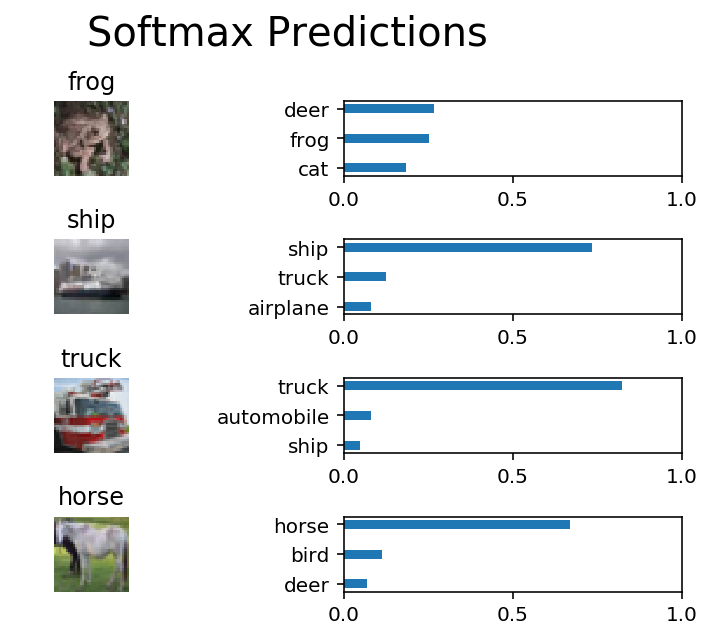

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()